# Dealing with massively imbalanced datasets for improved fraud detection in the banking sector.

Use of synthetic data generation to balance highly imbalanced classes, in particular, generation of synthetic fraudulent events.

The use of synthetic data for this type of use cases helps to improve the accuracy of fraud detection models in many different areas from the banking industry.


### Machine Learning and imbalanced datasets
Highly imbalanced datasets are extremely challenging for data teams, and they can be found very often in the industry, wether in topics such as detecting fraudulent events, but also for money laundry and even credit underwriting.

The commonnality between each one of these use cases? The fact that only a small portion of the overall transactions represent one particular class, for fraud problems, only a portion of those transactions were, in reality, a fraudulent event.

## Credit Fraud - a highly imbalanced dataset
The dataset in this example use case is from Kaggle - ["Credit Card Fraud detection"](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset, as for demonstration purposes we are only able to use datasets from the public domain.
This dataset includes labeled transactions from European credit car holders, and the data provided is a result from a dimensionality reduction, containing 27 continous features and a time column - the number of secons elapsed between the first and the last transaction of the dataset.

### The dataset Exploratory data analysis
(Include here some input on how highly imbalanced are the datasets)

(Include here some metrics and some validations that where done using YData's lib for data analysis)


In [41]:
!conda install -y scikit-learn==0.23.2 pandas==1.0.5 matplotlib==3.3.2 numpy==1.19.2


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - matplotlib==3.3.2
    - numpy==1.19.2
    - pandas==1.0.5
    - scikit-learn==0.23.2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB  defaults
    ca-certificates-2021.1.19  |       h06a4308_0         121 KB  defaults
    certifi-2020.12.5          |   py37h06a4308_0         141 KB  defaults
    cycler-0.10.0              |           py37_0          13 KB  defaults
    dbus-1.13.18               |       hb2f20db_0         504 KB  defaults
    expat-2.2.10               |       he6710b0_2         153 KB  defaults
    fontconfig-2.13.1          |       h6c09931_0         250 KB  defaults
    freetype-2.10.4            |       h5ab3b

In [42]:
#Download the data from kaggle and read it using pandas
from datetime import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ydata.connectors import GCSConnector, LocalConnector
from ydata.connectors.filetype import FileType
from pandas_profiling import ProfileReport

In [43]:
from pandas_profiling import ProfileReport

In [44]:
#Get the credit fraud dataset using ydata's GCS connector
credit = pd.read_csv("./creditcard.csv")

In [45]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This dataset is highly imbalanced. Let's check the behaviour of the imbalanced classes.

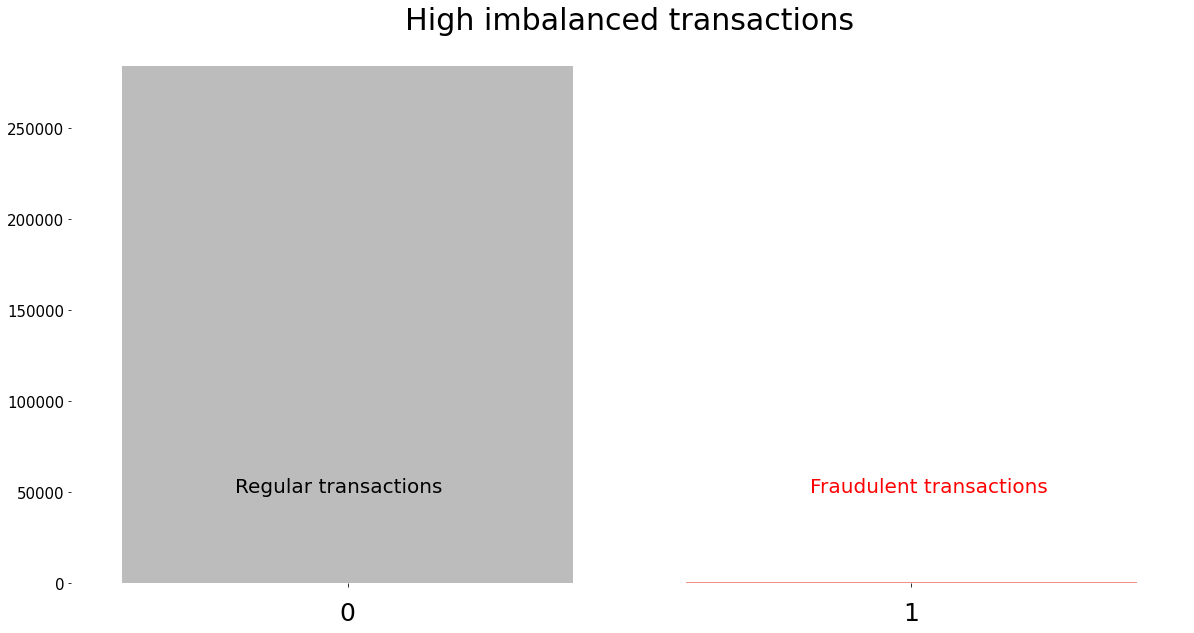

In [46]:
fig, ax = plt.subplots(figsize=(20,10))

#Remove the frame around
#Have this as an auxiliary function
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.bar([0, 1], pd.value_counts(credit['Class'].values, sort=True), alpha=0.5, color=['#7A7A7A','#E32212'])
plt.title('High imbalanced transactions', fontsize=30, pad=10)
plt.annotate('Fraudulent transactions', (0.82, 50000), fontsize=20, color='red')
plt.annotate('Regular transactions', (-0.2, 50000), fontsize=20, color='black')
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_ticks([0,1])
ax.tick_params(axis='x', which='major', pad=15)
ax.xaxis.set_tick_params(labelsize=25)

Text(0.5, 1.0, 'Scatter plot for V2 and V4 eigenvectors')

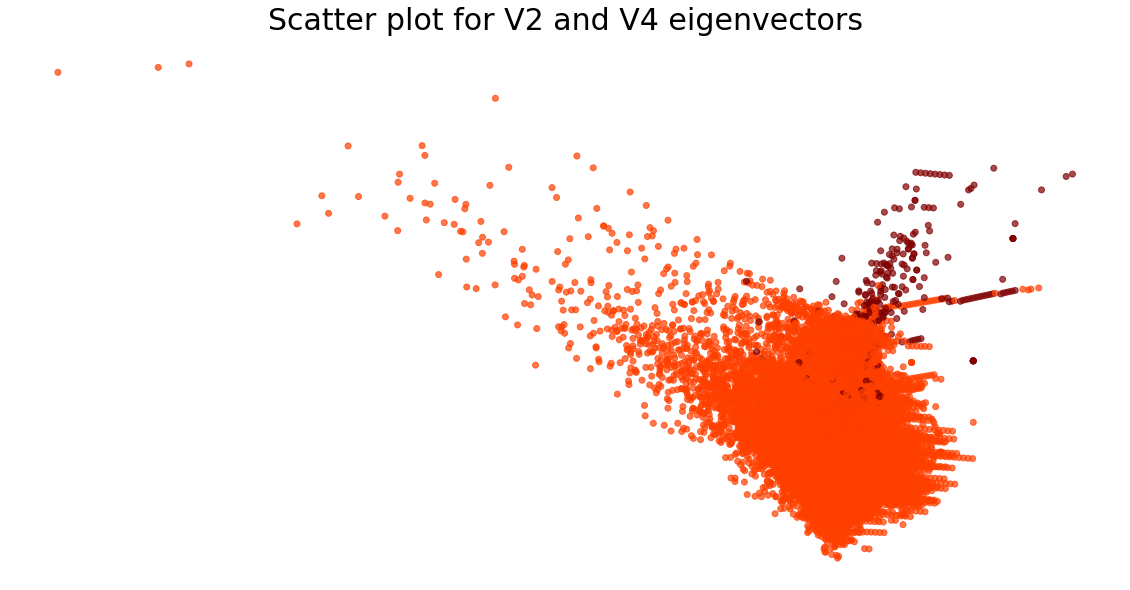

In [47]:
#Scatter plot with Class colouring the different elements from the plot
#As this dataset is the result of a PCA we will be using 2 eigen vectors for the plot
import matplotlib as m
import numpy as np

cmap = m.cm.jet(np.linspace(0,1,26))
cmap = m.colors.ListedColormap(cmap[21:,:-1])

fig, ax = plt.subplots(figsize=(20,10))

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.scatter(credit['V2'],credit['V4'], alpha=0.7, c=credit['Class'],cmap=cmap)
plt.axis('off')
plt.title('Scatter plot for V2 and V4 eigenvectors', fontsize=30, pad=10)

Splitting the dataset in train and test sets. The test set will be used again at the end of our iteration

In [48]:
X = credit.drop('Class', axis=1)
cols = X.columns
X = X.values
y = credit['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807


In [49]:
#profile = ProfileReport(pd.DataFrame(X_train, columns=cols), title='Credit Card fraud', explorative=True)

In [50]:
count_original = np.unique(y, return_counts=True)
count_train = np.unique(y_train, return_counts=True)
count_test = np.unique(y_test, return_counts=True)

print("Ratio between fraud and normal events for the \033[1mfull\033[0m  dataset:"+ " {:.2}%".format(count_train[1][1]/count_train[1][0]))
print("Ratio between fraud and normal events for the \033[1mtrain\033[0m dataset:"+ " {:.2}%".format(count_train[1][1]/count_train[1][0]))
print("Ratio between fraud and normal events for the \033[1mtest\033[0m dataset:"+" {:.2}%".format(count_test[1][1]/count_test[1][0]))

Ratio between fraud and normal events for the full  dataset: 0.0017%
Ratio between fraud and normal events for the train dataset: 0.0017%
Ratio between fraud and normal events for the test dataset: 0.0017%


### The first model
Let's try to develop a model based on the assumption that everything is ok with our dataset, and understand how good is our classifier to indetify fraudulent events.
Here we've decided to develop a classifier using [RandomForest from the scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) package.

In [51]:
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

In [52]:
#Data scaling and preprocessing before training the model
from sklearn.preprocessing import RobustScaler, StandardScaler

def preprocess_df(df, std_scaler, rob_scaler):
    df['Amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
    df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
    return df

In [53]:
stdscaler = StandardScaler()
robscaler = RobustScaler()

X_train = preprocess_df(X_train, stdscaler, robscaler)

In [54]:
#Apply the same trasnformation to the test dataset
X_test = preprocess_df(X_test, stdscaler, robscaler)

In [55]:
#Using XGBOOST model to train the model
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


def XGBoost_Classifier(X, y, Xtest):
    """XGBoost training code"""
    classifier = XGBClassifier()
    print('Start fitting XGBoost classifier')
    classifier.fit(X, y)
    y_pred = classifier.predict(Xtest)
    print('Classifier trained.')
    return classifier, y_pred

classifier_model, y_pred = XGBoost_Classifier(X_train, y_train, X_test)

Start fitting XGBoost classifier
Classifier trained.


In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Print precision / recall report
print('Overall accuracy score :',accuracy_score(y_test, y_pred))
print('Classifier performance report: ')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

Overall accuracy score : 0.9995318516437859
Classifier performance report: 
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85296
       Fraud       0.96      0.76      0.85       147

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



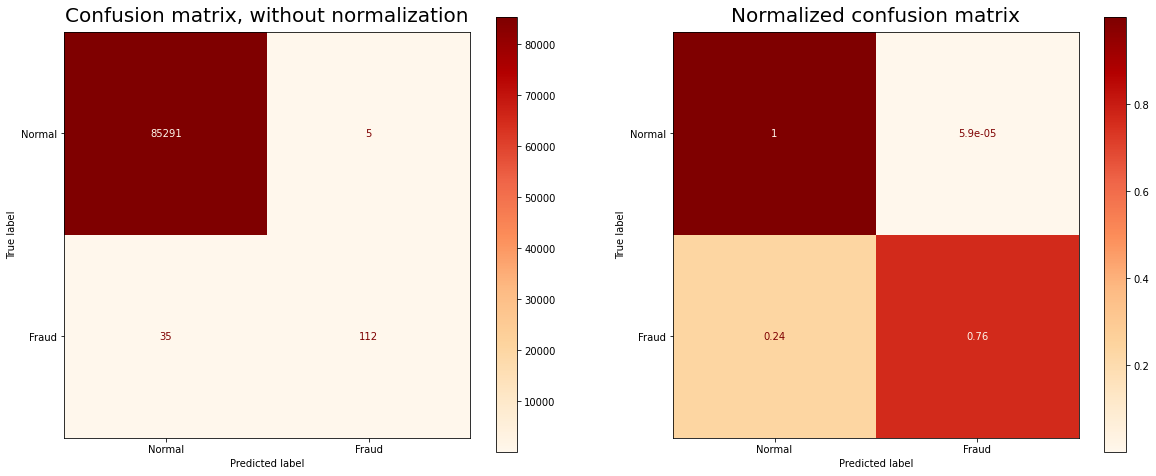

In [57]:
#Now let's check the real metrics for this classifier
from sklearn.metrics import plot_confusion_matrix


def print_confusion_matrix(model, X_test, y_test):
    """ Plot normalized and non-normalized confusion matrices """
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    fig, axes = plt.subplots(1,2,figsize=(20,8))
    for (title, normalize), ax in zip(titles_options, axes):

        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=["Normal", "Fraud"],
                                     cmap=plt.cm.OrRd,
                                     normalize=normalize,
                                     ax=ax)

        ax.set_title(title, fontsize=20, pad=10)

print_confusion_matrix(classifier_model, X_test, y_test)

## Synthetic data to improve the detection of fraud

### Synthetic data with YData synthesizer package

In this case the objective is to synthesize only the fraudulent events. Through the augmentation of fraudulent events we are able to improve the results the results of our classifier.

In [58]:
#Let's filter by fraudulent events only
aux = X_train.copy()
aux['y'] = y_train.reset_index()['Class']

non_fraud = aux[aux['y'] == 0]
fraud = aux[aux['y']==1]

del aux

In [59]:
#Have here YData's lib to be called and used in the Jupyter Notebook
from ydata.synthesizers.regular import RegularSynthesizer

fraud_synth = RegularSynthesizer()
fraud_synth.fit(fraud)
synthetic_fraud = fraud_synth.sample(n_samples=400)
synthetic_fraud.to_csv('./synthetic_fraud.csv', index=False)

INFO: 2021-02-12 16:05:47,404 Infer data types.
INFO: 2021-02-12 16:05:47,405 Input data shape: 345 rows, 31 columns.
INFO: 2021-02-12 16:05:47,427 Synthesizer init. Synthesizer: GMM
INFO: 2021-02-12 16:05:47,428 Initializing the data processing step.
INFO: 2021-02-12 16:05:47,429 Start - Fitting float data types.
INFO: 2021-02-12 16:05:47,431 End - Fitting float data types.
INFO: 2021-02-12 16:05:47,432 Start - Fitting int data types.
INFO: 2021-02-12 16:05:47,433 End - Fitting int data types.
INFO: 2021-02-12 16:05:47,433 Start - Fitting categorical data types.
INFO: 2021-02-12 16:05:47,438 Start GPU training. Encoding categorical variables.
INFO: 2021-02-12 16:05:47,438 Building the categorical encoder model.
INFO: 2021-02-12 16:05:48,278 Finishing GPU training. Ended encoding categorical variables.
INFO: 2021-02-12 16:05:48,329 End - Fitting categorical data types.
INFO: 2021-02-12 16:05:48,330 Start - Fitting date data types.
INFO: 2021-02-12 16:05:48,331 End - Fitting date data t

## Visualizing the generated synthetic data

In [60]:
#Read the synthetic fraud generated events 
#local_conn = LocalConnector()
#synthetic = local_conn.read_file('synthetic_fraud.csv', file_type=FileType.CSV)

synthetic = pd.read_csv('./synthetic_fraud.csv')
synth_df = synthetic.copy()
org_df = X_train.copy()

org_df['Class'] = y_train.reset_index()['Class']
org_df['color'] = np.where(org_df['Class']==1, 2, 1)

synth_df['Class'] = synthetic['y']
synth_df = synth_df.drop('y', axis=1)
synth_df['color'] = 3

full_data = pd.concat([org_df, synth_df])

Using a PCA we are able to  reduce the dimensionality of the dataset and and better visualize the relation between both the synthetic fraud generated events and the ones from the original data, regardless they're fraud or normal events. 

The randomness introduced by the synthetic data can help the model to generalize for a new dataset and new fraud events never previously observed.

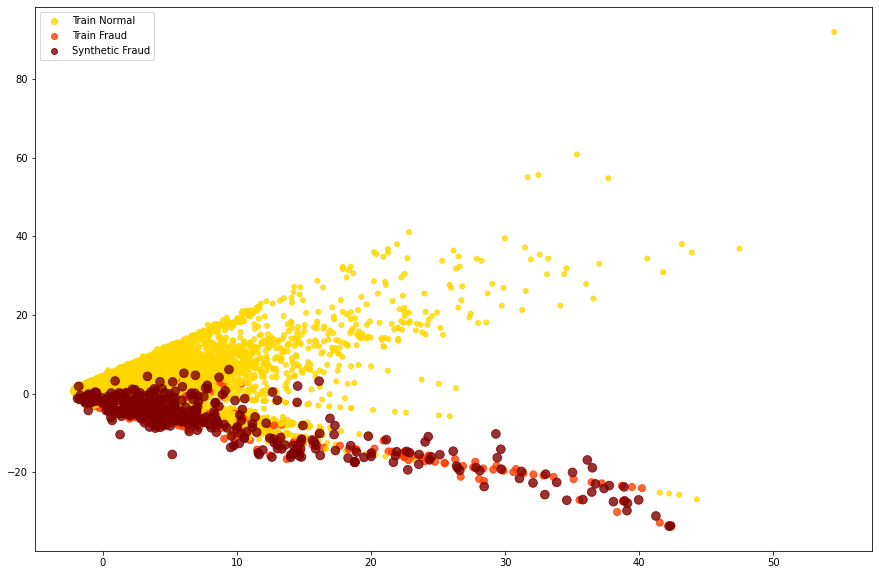

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = full_data.iloc[:, :-2]
color = full_data['color']

fig = plt.figure(1, figsize=(15, 10))
plt.clf()
plt.cla()

cmap = m.cm.jet(np.linspace(0,1,26))
cmap = m.colors.ListedColormap(cmap[17:,:-1])

pca = PCA(n_components=2)
projected = pca.fit_transform(X)

labels = ['Train Normal', 'Train Fraud', 'Synthetic Fraud']

size_map = {1:25, 2:50, 3:75}
sizes = [size_map[x] for x in color]

scatter = plt.scatter(projected[:, 0], projected[:, 1],
                      s=sizes,
                      c=color,
                      cmap=cmap, 
                      alpha=0.8)

plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.show()

### Testing the classifier capacity after adding more fraudulent events

In [62]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([85296,   147]))

In [63]:
synth_y_train = synthetic['y']
synth_train = synthetic.drop('y', axis=1)

X_augmented = pd.concat([X_train, synth_train], axis=0)
y_augmented = pd.concat([y_train, synth_y_train], axis=0)

In [64]:
synth_classmodel, y_pred = XGBoost_Classifier(X_augmented, y_augmented, X_test)

Start fitting XGBoost classifier
Classifier trained.


In [65]:
# Print precision / recall report
print('Overall accuracy score :',accuracy_score(y_test, y_pred))
print('Classifier performance report: ')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

Overall accuracy score : 0.9995435553526912
Classifier performance report: 
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85296
       Fraud       0.92      0.81      0.86       147

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



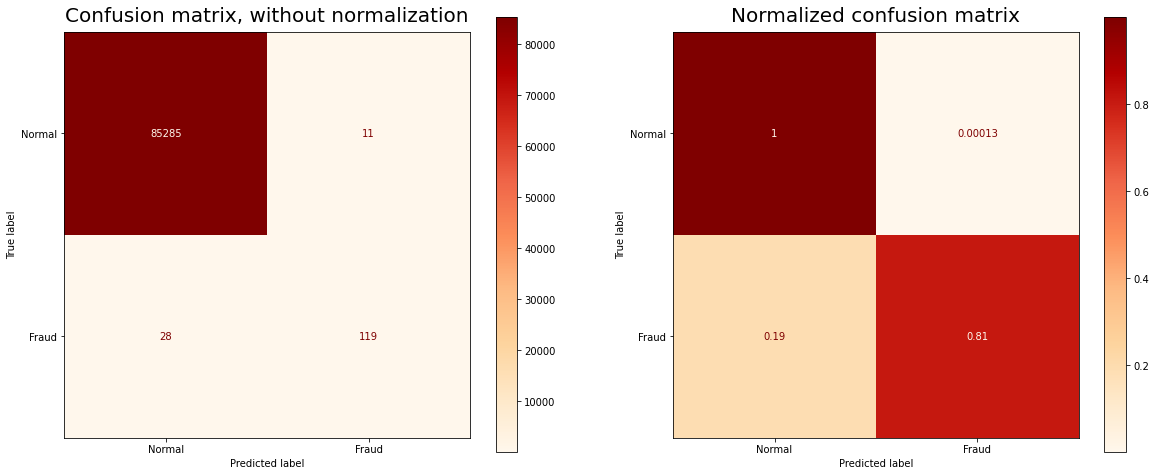

In [66]:
print_confusion_matrix(synth_classmodel, X_test, y_test)

In [67]:
synth_classmodel

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Serialize the model with joblib

In [68]:
import joblib
joblib_model = "xgb_with_synth.joblib"
joblib.dump(synth_classmodel, joblib_model)

['xgb_with_synth.joblib']

In [69]:
full_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,color
0,0.343717,-0.132066,0.107044,-0.650588,-0.996032,1.814333,1.740740,0.496852,0.633016,0.017181,...,0.005292,0.251519,-2.466810,-0.889690,0.337462,0.306395,0.074817,-0.165692,0,1
1,0.594843,2.125994,0.014207,-1.514760,0.115021,0.598510,-0.333235,0.199289,-0.264353,0.384111,...,-0.788150,0.267730,0.066122,-0.135785,0.203841,-0.068267,-0.057678,-0.352239,0,1
2,0.479584,-0.086694,0.166240,1.573127,0.687266,0.222359,1.102606,1.575093,-1.098608,0.763887,...,1.063663,-0.410841,0.722723,-0.171733,-0.613543,-1.201571,-1.139931,0.330886,0,1
3,-0.599866,1.352339,-0.534984,0.555143,-0.629355,-1.144170,-0.852967,-0.642128,-0.032659,-0.654482,...,-0.180379,0.178112,0.347720,0.151810,-0.404361,0.013746,0.016152,-0.336067,0,1
4,0.710242,-1.526760,0.647782,0.615391,-0.561114,0.836950,-0.514251,0.984325,-0.097430,-0.062634,...,-0.393158,-0.214990,0.588447,0.679496,0.518434,0.065022,0.147294,0.005211,0,1


### Create sample inputs and test them


In [70]:
#Create sample inputs for both "Fraudulent" and "Genuine" transactions

sample_input = credit[credit["Class"]==0].iloc[0:1].drop("Class", axis=1)
sample_input1 = credit[credit["Class"]==1].iloc[0:1].drop("Class", axis=1)

sample_input.to_csv("sample_input.csv", index=False)
sample_input1.to_csv("sample_input1.csv", index=False)

In [71]:
import pandas as pd 
import numpy as np

sample_input = pd.read_csv("sample_input.csv")

#Test sample prediction

xgb_synth = joblib.load('xgb_with_synth.joblib')
xgb_synth.predict(sample_input)

array([0])

In [72]:
sample_input1 = pd.read_csv("sample_input1.csv")
xgb_synth.predict(sample_input1)

array([1])

# Algorithmia

This part of the notebook creates a Data Collection on Algorithmia for storing the Data .csv files and the model pickle files. 
Once the pickled model is uploaded, an Algorithm needs to be created from the Algorithmia Web IDE or your PC

It requires that you have created a free Algorithmia account first, to run this code. 

Note your Username, Password and API key for the Algorithmia account

In [113]:
!conda install -y -c anaconda pip
!pip install algorithmia==1.7.8

Solving environment: done

# All requested packages already installed.



In [114]:
### Setup Algorithmia Credentials

# Enter Your Algorithmia API key
api_key = "simXXXXXXXXXXXXXXXXXXXXXXXXX-enter-your-api-key" 

# Create an API key with BOTH "Read & Write Data" and "Manage Algorithms": 
# https://algorithmia.com/user#credentials

# Define your username & algorithm name, this will be used later
username = "your-username"   #Enter your username here
algoname = "xgboost_with_synthetic_data"   #Enter your algorithm name here 

if username == "username":
    raise Exception("Don't forget to provide your username!")
elif api_key == "simXXXXXXXXXXXXXXXXXXXXXXXXX":
    raise Exception("Don't forget to provide your API key")

In [115]:
import Algorithmia
from Algorithmia.errors import AlgorithmException

data_path = "data://.my/ydata_demo"

# Create a new algorithmia client
client = Algorithmia.client(api_key)

In [116]:
# Create data collection if it doesn't exist
if not client.dir(data_path).exists():
    client.dir(data_path).create()

from Algorithmia.acl import ReadAcl, AclType

# Instantiate a DataDirectory object, set your data URI and call create
data_dir = client.dir(data_path)

# Change permissions on your data collection to public
data_dir.update_permissions(ReadAcl.public)

True

In [117]:
#Upload Model and Sample Inputs to Algorithmia Data Collection

data_model_name = "{}/{}".format(data_path, joblib_model)
_ = client.file(data_model_name).putFile(joblib_model)

sample_input_path = "{}/sample_input.csv".format(data_path)
_ = client.file(sample_input_path).putFile("./sample_input.csv")

sample_input_path1 = "{}/sample_input1.csv".format(data_path)
_ = client.file(sample_input_path1).putFile("./sample_input1.csv")


In [121]:
#Create the Algorithm

# Algorithms are refered with the following schema: username/algoname
algo_namespace = "{}/{}".format(username, algoname)

# Here are some details you can define for your algorithm
details = {
    "summary": "Fraud Prediction with a synthetic data training boost",
    "label": "Credit Card Fraud Prediction",
    "tagline": '["Synthetic Data", "YData", "Credit Card", "Fraud Prediction", "XGBoost"]'
}

settings = {
    "source_visibility": "open",
    "package_set": "tensorflow-gpu-1.13",
    "license": "apl",
    "network_access": "full",
    "pipeline_enabled": True
}

In [122]:
# Let's also provide a sample input for our algorithm
version_info = {
    "sample_input": "data://{}/ydata_demo/sample_input.csv".format(username)
}

print("Algorithm namepace: {}".format(algo_namespace))

Algorithm namepace: demoydata/xgboost_with_synthetic_data


In [123]:
# Create a new algorithm
client.algo(algo_namespace).create(details, settings, version_info)

{'details': {'label': '["Synthetic Data", "YData", "Credit Card", "Fraud '
                      'Prediction", "XGBoost"]',
             'summary': 'Fraud Prediction with a synthetic data training boost',
             'tagline': 'Credit Card Fraud Prediction'},
 'id': '0ae390ee-b793-4aff-aae5-433b05e1619c',
 'name': 'xgboost_with_synthetic_data',
 'self_link': None,
 'settings': {'algorithm_callability': 'private',
              'algorithm_environment': '10e22c9d-2833-4b3b-b06d-a0d90a434a75',
              'environment': None,
              'language': None,
              'license': 'apl',
              'network_access': 'full',
              'package_set': 'tensorflow-gpu-1.13',
              'pipeline_enabled': True,
              'royalty_microcredits': None,
              'source_visibility': 'open'},
 'source': {'repository_https_url': None,
            'repository_name': None,
            'repository_owner': None,
            'repository_ssh_url': None,
            'scm': {'defau

## Further steps 

The files in the Algorithmia algorithm need to be modified for your algo to run properly
Either the YData Labs Git extension, the Algorithmia IDE or the YData Labs terminal needs to be used.

### Instructions for YData Labs Git

- Click on the 'Git' tab in the left side-bar, and the click on 'Clone a Repository'
- Enter the link for your algorithm Git repository, with the generic format 

https://git.algorithmia.com/git/username/algorithmname.git

- Enter your Algorithmia username and password for authentication
    
The Algorithm repository will be cloned inside your current directory
    
### Instructions for YData Labs Terminal
Clone the Algorithm repository (It'll ask for your algorithmia account username and password) - 

`$ git clone https://git.algorithmia.com/git/demoydata/xgboost_with_synthetic_data.git`

or using the YData Labs Git extension

Go inside the Repository directory

Edit the following files - 
- requirements.txt
- src/xgboost_with_synthetic_data.py
- src/xgboost_with_synthetic_data_test.py

In [139]:
%%writefile "./xgboost_with_synthetic_data/requirements.txt"

algorithmia==1.7.8
numpy==1.19.2
pandas==1.1.5
xgboost==1.2.1
fsspec==0.8.5
joblib==1.0.0
scikit-learn==0.23.0
six==1.15.0

Overwriting ./xgboost_with_synthetic_data/requirements.txt


In [140]:
%%writefile "./xgboost_with_synthetic_data/src/xgboost_with_synthetic_data_test.py"

import Algorithmia
import numpy as np
import pandas as pd
import joblib
from xgboost import XGBClassifier


client = Algorithmia.client()
    
def load_model():
    # Get file by name
    # Open file and load model
    file_path = 'data://demoydata/ydata_demo/xgb_with_synth.joblib'
    model_path = client.file(file_path).getFile().name
    
    # # Open file and load model
    
    with open(model_path, 'rb') as f:
         model = joblib.load(f)
         print("model loaded")
    
    #model = joblib.load(model_path)
    return model
    
model = load_model()


def process_input(input):
    # Create numpy array from csv file passed as input in apply()
    
    file_url=str(input)
    
    if input.startswith('data:'):
        file_url = client.file(input).getFile().name
        
    return pd.read_csv(file_url)


def apply(input):
    data_sample = process_input(input)
    prediction = model.predict(data_sample)
    
    if(list(prediction)[0] == 1):
        return "Fraud"

    return "Genuine"

Overwriting ./xgboost_with_synthetic_data/src/xgboost_with_synthetic_data_test.py


In [141]:
%%writefile "./xgboost_with_synthetic_data/src/xgboost_with_synthetic_data_test.py"

from .xgboost_with_synthetic_data import apply

def test_algorithm():
    file_path = 'data://demoydata/ydata_demo/sample_input.csv'
    input = client.file(file_path).getFile().name
    result = apply(input)
    assert result == "Genuine"

Overwriting ./xgboost_with_synthetic_data/src/xgboost_with_synthetic_data_test.py






Push the repository files back to Algorithmia to build the algorithm - 




### Using YData Labs Git extension
- Enter the repository directory ("xgboost_with_syntetic_data" for this demo)
- Click on the 'Git' button in the left side-bar
- It will display the tracked changes
- Click on the "+" icon in the 'Changed' files section which you want to commit
- Those files should now be visible in the 'Staged' files section
- Enter the summary and description and click on "Commit"
- Enter your Algorithmia username and password
- Once the changes have been comitted, click on "Push" changes in the top left corner to Push them to algorithmia





### Using the YData Labs Terminal

Run the following commands to Push the changes to Algorithmia

`$ git remote add algo https://git.algorithmia.com/git/rujual/xgboost_with_synthetic_data.git`

`$ git commit -m "Commit on: <Date>"`

`$ git push algo master`

Algorithmia automatically executes a "Build" when changes are pushed into the repository





### Instructions for Algorithmia IDE 

Enter the Algorithmia IDE for the algorithm by navigating to `https://algorithmia.com/algorithms/<username>/<algoname>/source`

For this algorithm - https://algorithmia.com/algorithms/rujual/xgboost_with_synthetic_data/source


Edit the following files (for this algorithm, just copy-paste the code for the same files in the Notebook cells above into your version) - 
- requirements.txt
- src/xgboost_with_synthetic_data.py
- src/xgboost_with_synthetic_data_test.py

Edit the "Dependencies" file also same as the "requirements.txt" file

Click on "Build" 

# Test the Algorithm

In [7]:
import Algorithmia

username = "rujual"
input = "data://{}/ydata_demo/sample_input1.csv".format(username)
client = Algorithmia.client('simvxMn0MiL3T+AwwNPcR/xQL801')
algo = client.algo('{}/xgboost_with_synthetic_data/1.0.0'.format(username))
algo.set_options(timeout=300) # optional
print(algo.pipe(input).result)

Fraud


In [8]:
import Algorithmia

input = "data://{}/ydata_demo/sample_input.csv".format(username)
client = Algorithmia.client('simvxMn0MiL3T+AwwNPcR/xQL801')
algo = client.algo('{}/xgboost_with_synthetic_data/1.0.0'.format(username))
algo.set_options(timeout=300) # optional
print(algo.pipe(input).result)

Genuine
